# Handwritten digit classification using autoencoders

- Autoencoders are a neural network architecture. They have same input and output shape and have a symmetric shape, with the vectors shrinking to form a small vector in the middle, which is called the "encoded vector", which is then expanded by a "decoder" network to get an output with the same shape as the input.

- They can be used to learn compressed encodings of data in an **unsupervised** environment (no need of labelled data). This is why they are called autoencoders. This training can be done by giving it some input and training it to retreive the same input from the encoded vector.

- They are used for 

1. Denoising
2. In generative networks
3. For transfer learning
and many more

Source of code : https://github.com/iitkliv/dlvcnptel/blob/master/lecture12.ipynb

---

## Importing libraries and dataset

In [132]:

%matplotlib inline
import os
import copy
import torch
import codecs
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets

print(torch.__version__)

1.5.0


In [133]:
# Downloading MNIST dataset
download = datasets.MNIST("./MNIST/", train=True, download=True)

In [134]:
# Path for storing data
Datapath = "MNIST/MNIST/raw/"

## Defining basic functions needed

In [135]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [136]:
def parse_byte(b):
    if isinstance(b, str):
        return ord(b)
    return b

In [137]:
def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        idx = 16
        for l in range(length):
            img = []
            images.append(img)
            for r in range(num_rows):
                row = []
                img.append(row)
                for c in range(num_cols):
                    row.append(parse_byte(data[idx]))
                    idx += 1
        assert len(images) == length
        return torch.ByteTensor(images).view(-1,784)

In [138]:
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        labels = [parse_byte(b) for b in data[8:]]
        assert len(labels) == length
        return torch.LongTensor(labels)

In [139]:
TrainImages = read_image_file(os.path.join(Datapath, 'train-images-idx3-ubyte'))
TrainLabels = read_label_file(os.path.join(Datapath, 'train-labels-idx1-ubyte'))
TestImages = read_image_file(os.path.join(Datapath, 't10k-images-idx3-ubyte'))
TestLabels = read_label_file(os.path.join(Datapath, 't10k-labels-idx1-ubyte'))

In [140]:
print("Train images size : " + str(TrainImages.size()))
print("Train labels size : " + str(TrainImages.size()))
print("Test images size  : " + str(TrainImages.size()))
print("Test labels size  : " + str(TrainImages.size()))

Train images size : torch.Size([60000, 784])
Train labels size : torch.Size([60000, 784])
Test images size  : torch.Size([60000, 784])
Test labels size  : torch.Size([60000, 784])


In [141]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU is available!")
    device = "cuda"
else:
    print("GPU is not available")
    device = "cpu"

GPU is available!


## Defining the autoencoder

In [142]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28, 100), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(100, 28*28), nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
net = autoencoder()
print(net)

net = net.double().to(device)

init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


## Defining optimizer

In [143]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1.5, momentum=0.5)

## Training the autoencoder

In [144]:
iterations = 50
BatchSize = 10000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)):
        inputs = torch.index_select(TrainImages, 0, torch.linspace(i*BatchSize, (i+1)*BatchSize-1, steps=BatchSize).long()).double()
        inputs = inputs/255
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    print(" Iteration %3d/%3d, loss was %2.3f"%(epoch+1, iterations, runningLoss/(epoch+1)))
print("Finished training")

 Iteration   1/ 50, loss was 0.622
 Iteration   2/ 50, loss was 0.287
 Iteration   3/ 50, loss was 0.174
 Iteration   4/ 50, loss was 0.120
 Iteration   5/ 50, loss was 0.091
 Iteration   6/ 50, loss was 0.074
 Iteration   7/ 50, loss was 0.062
 Iteration   8/ 50, loss was 0.053
 Iteration   9/ 50, loss was 0.046
 Iteration  10/ 50, loss was 0.040
 Iteration  11/ 50, loss was 0.036
 Iteration  12/ 50, loss was 0.032
 Iteration  13/ 50, loss was 0.030
 Iteration  14/ 50, loss was 0.027
 Iteration  15/ 50, loss was 0.025
 Iteration  16/ 50, loss was 0.023
 Iteration  17/ 50, loss was 0.021
 Iteration  18/ 50, loss was 0.020
 Iteration  19/ 50, loss was 0.018
 Iteration  20/ 50, loss was 0.017
 Iteration  21/ 50, loss was 0.016
 Iteration  22/ 50, loss was 0.015
 Iteration  23/ 50, loss was 0.014
 Iteration  24/ 50, loss was 0.013
 Iteration  25/ 50, loss was 0.012
 Iteration  26/ 50, loss was 0.012
 Iteration  27/ 50, loss was 0.011
 Iteration  28/ 50, loss was 0.011
 Iteration  29/ 50, 

## Visualising result

[]

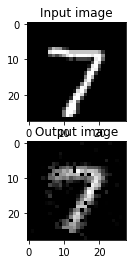

In [145]:
test_img = TestImages[0]

output_img = net((test_img.double().to(device))/255).data
output_img = (output_img*255).byte()
output_img = output_img.view(-1, 28, 28)

if device == "cuda":
    output_img = output_img.cpu()

test_img = test_img.view(-1, 28, 28)

plt.subplot(2,1,1)
img = np.array(test_img.numpy())[0]
plt.title("Input image")
plt.imshow(img, cmap="gray")

plt.subplot(2,1,2)
out_img = np.array(output_img.numpy())[0]
plt.title("Output image")
plt.imshow(out_img, cmap="gray")

plt.plot()

## Encoder weights visualisation

In [146]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)

Text(0.5,1,'Updation of weights')

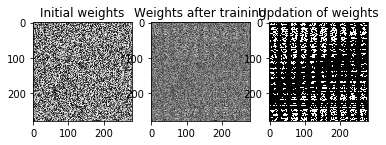

In [147]:
init_weights = (1 + init_weights)*127.5
trained_weights = (1 + trained_weights)*127.5

if use_gpu:
    init_weights = init_weights.view(-1, 280, 280).byte().cpu()
    trained_weights = trained_weights.view(-1, 280, 280).byte().cpu()
else:
    init_weights = init_weights.view(-1,280,280).byte()
    trained_weights = trained_weights.view(-1, 280, 280).byte()

d_weights = init_weights - trained_weights

plt.subplot(131)
plt.imshow(init_weights.numpy()[0], cmap="gray")
plt.title("Initial weights")

plt.subplot(132)
plt.imshow(trained_weights.numpy()[0], cmap="gray")
plt.title("Weights after training")

plt.subplot(133)
plt.imshow(d_weights.numpy()[0], cmap="gray")
plt.title("Updation of weights")

## Adding classification layer

In [148]:
classifier = nn.Sequential()
classifier_net = classifier
classifier_net.add_module("encoder_copy", list(net.children())[0])
classifier_net.add_module("classifier", nn.Sequential(nn.Linear(100,10), nn.LogSoftmax(dim=1)))

# Locking the encoder layer (its values will not be changed during training)
lock = False
for i in list(classifier_net.children())[0][0].parameters():
    i.requires_grad = not lock

classifier_net.double().to(device)

init_weights_2 = copy.deepcopy(classifier_net[0][0].weight.data)

## Defining optimizer again

In [149]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(classifier_net.parameters(), lr=0.01, momentum=0.9)

## Training the clasiffier

In [150]:
iterations = 30
batchsize = 50000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize).long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize).long()).long()
        inputs = inputs/255
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = classifier_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        
    inputs = TestImages.double()/255    
    inputs = inputs.to(device)
    outputs = classifier_net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    if device == 'cuda':
        predicted = predicted.cpu()
        
    correct = 0
    total = 0
    total += TestLabels.size(0)
    correct += (predicted == TestLabels).sum()
    print(' Iteration: %d / %d  ;  Training Loss: %f ; Testing Acc: %f '%(epoch + 1,iterations,runningLoss/
                                                                            (TrainImages.shape[0]/
                                                                             BatchSize),(100 * correct/ float(total))))
print('Finished Training')

 Iteration: 1 / 30  ;  Training Loss: 2.392063 ; Testing Acc: 24.209999 
 Iteration: 2 / 30  ;  Training Loss: 2.134340 ; Testing Acc: 42.060001 
 Iteration: 3 / 30  ;  Training Loss: 1.843596 ; Testing Acc: 62.869999 
 Iteration: 4 / 30  ;  Training Loss: 1.558184 ; Testing Acc: 68.720001 
 Iteration: 5 / 30  ;  Training Loss: 1.324036 ; Testing Acc: 75.269997 
 Iteration: 6 / 30  ;  Training Loss: 1.137822 ; Testing Acc: 78.620003 
 Iteration: 7 / 30  ;  Training Loss: 0.998299 ; Testing Acc: 80.080002 
 Iteration: 8 / 30  ;  Training Loss: 0.893167 ; Testing Acc: 80.720001 
 Iteration: 9 / 30  ;  Training Loss: 0.814100 ; Testing Acc: 81.790001 
 Iteration: 10 / 30  ;  Training Loss: 0.753492 ; Testing Acc: 82.720001 
 Iteration: 11 / 30  ;  Training Loss: 0.705631 ; Testing Acc: 83.480003 
 Iteration: 12 / 30  ;  Training Loss: 0.666997 ; Testing Acc: 84.269997 
 Iteration: 13 / 30  ;  Training Loss: 0.635088 ; Testing Acc: 84.930000 
 Iteration: 14 / 30  ;  Training Loss: 0.608233

## Encoder weights visualisation (again)

In [151]:
trained_weights_2 = copy.deepcopy(classifier_net[0][0].weight.data)

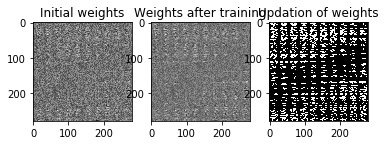

In [152]:
init_weights_2 = (1 + init_weights_2)*127.5
trained_weights_2 = (1 + trained_weights_2)*127.5

if use_gpu:
    init_weights_2 = init_weights_2.view(-1, 280, 280).byte().cpu()
    trained_weights_2 = trained_weights_2.view(-1, 280, 280).byte().cpu()
else:
    init_weights_2 = init_weights_2.view(-1,280,280).byte()
    trained_weights_2 = trained_weights_2.view(-1, 280, 280).byte()

d_weights_2 = init_weights_2 - trained_weights_2

plt.subplot(131)
plt.imshow(init_weights_2.numpy()[0], cmap="gray")
plt.title("Initial weights")

plt.subplot(132)
plt.imshow(trained_weights_2.numpy()[0], cmap="gray")
plt.title("Weights after training")

plt.subplot(133)
plt.imshow(d_weights_2.numpy()[0], cmap="gray")
plt.title("Updation of weights")

plt.show()

## Output visualisation

Test set index no : 1290


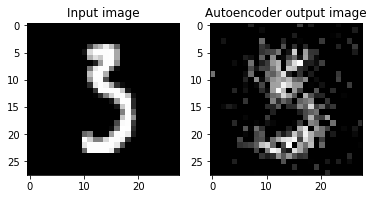

 Output of classifier : 3 
 Label : 3 

Test set index no : 2665


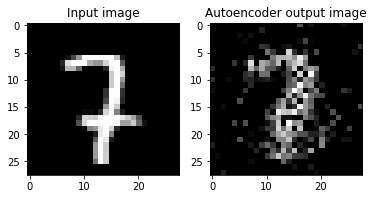

 Output of classifier : 2 
 Label : 7 

Test set index no : 4288


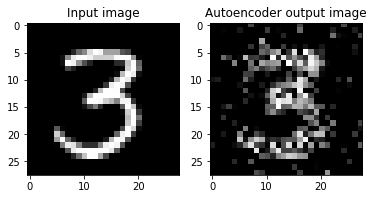

 Output of classifier : 3 
 Label : 3 

Test set index no : 2495


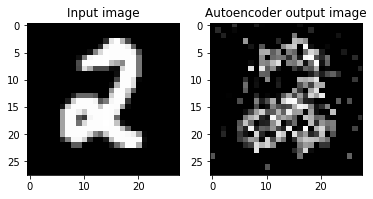

 Output of classifier : 2 
 Label : 2 

Test set index no : 7637


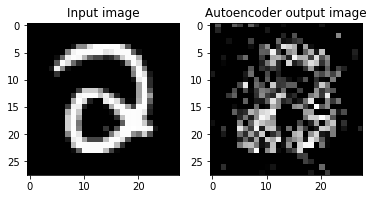

 Output of classifier : 0 
 Label : 2 

Test set index no : 1668


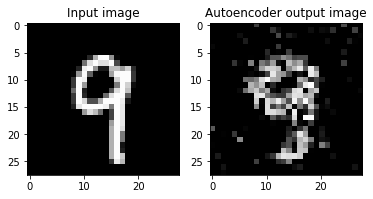

 Output of classifier : 9 
 Label : 9 

Test set index no : 1641


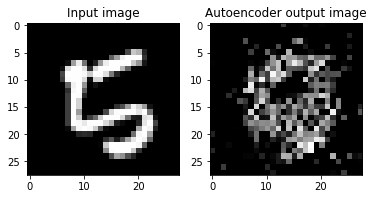

 Output of classifier : 0 
 Label : 5 

Test set index no : 287


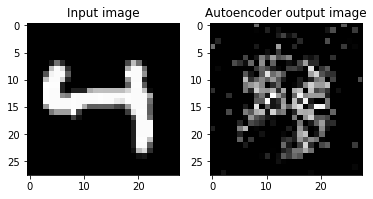

 Output of classifier : 4 
 Label : 4 

Test set index no : 207


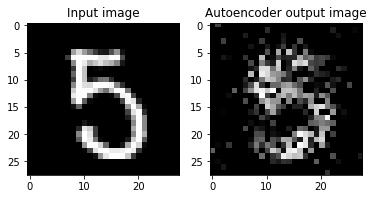

 Output of classifier : 5 
 Label : 5 

Test set index no : 1756


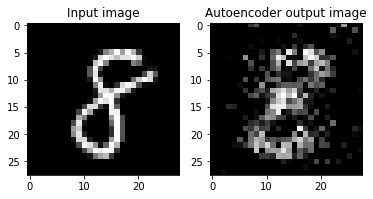

 Output of classifier : 8 
 Label : 8 



In [153]:
indices = np.random.uniform(0,TestImages.shape[0],size=10)

for index in indices:
    index = int(index)

    print("Test set index no : %d"%index)

    test_img = TestImages[index].reshape(1,784)

    output = classifier_net((test_img.double().to(device))/255)
    output_img = net((test_img.double().to(device))/255).data
    output_img = (output_img*255).byte()
    output_img = output_img.view(-1, 28, 28)
    if device == "cuda":
        output = output.cpu()
        output_img = output_img.cpu()

    test_img = test_img.view(-1, 28, 28)

    plt.subplot(1,2,1)
    img = np.array(test_img.numpy())[0]
    plt.title("Input image")
    plt.imshow(img, cmap="gray")

    plt.subplot(1,2,2)
    img = np.array(output_img.numpy())[0]
    plt.title("Autoencoder output image")
    plt.imshow(img, cmap="gray")
    plt.show()

    print(" Output of classifier : %d "%np.argmax(output.detach().numpy()))
    print(" Label : %d "%TestLabels[index])
    print()

While training the classifier, the encoder layer was also trained. This is why the autoencoder output is more noisier than before. This can be solved by 

1. Copying the encoder layer using copy.deepcopy() for creating the classifier
2. Freeezing the encoder layer  while training the classifier
3. Freezing the encoder layer and train the autoencoder again (this time, only decoder layer will be trained) to improve reconstruction

However, both of these are unnecessary since the reconstructed autoencoder output is not used in our use case (recognising digits).

Just for curiosity, run this block to lock the encoder layer and run the auotencoder training code again to improve reconstructon without affecting classification performance. Not freezing the encoder layer will mess up the classification performance, since the classification layer was optimized for the other version of the encoder. While forming the classification layer, there is some code that can lock or unlock the encoder layer for the same purpose.

In [154]:
# Setting the requires_grad option in enables training that layer using gradient descent. 
list(list(net.children())[0][0].parameters())[0].requires_grad = True

Check this [link](https://pytorch.org/docs/stable/notes/autograd.html) to see how requires_grad freezes layers and how automatic differentiation works in pytorch.